In [1]:
import os
import nibabel as nib
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

## Plot Anatomical Planes

In [46]:
def display_views(file_path):
    image_axis = 2
    medical_image = nib.load(file_path)
    image = medical_image.get_data()
    
    sagital_image = image[110, :, :] # Axis 0
    axial_image = image[:, :, 144] # Axis 2
    coronal_image = image[:, 144, :] # Axis 1
    
    plt.figure(figsize=(20, 10))
    plt.style.use('grayscale')
    
    plt.subplot(141)
    plt.imshow(np.rot90(sagital_image))
    plt.title('Sagital Plane')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(np.rot90(axial_image))
    plt.title('Axial Plane')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(np.rot90(coronal_image))
    plt.title('Coronal Plane')
    plt.axis('off')

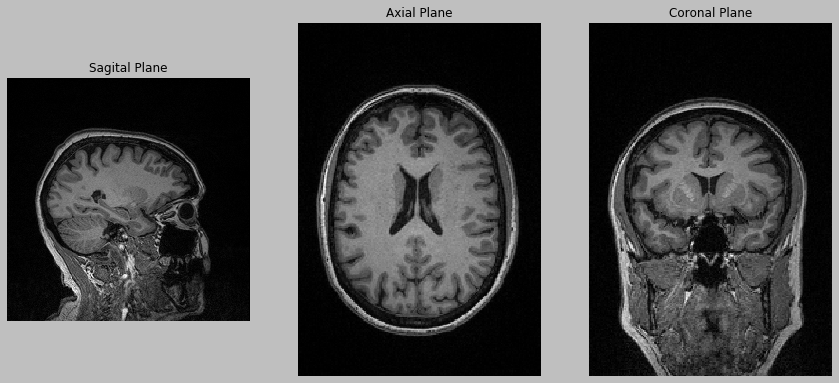

In [47]:
display_views('example_1_T1w.nii.gz')

## Load Images

In [4]:
def load_mr_image(file_path, slice=144):
    image_axis = 2
    medical_image = nib.load(file_path)
    image = medical_image.get_data()
    shape = medical_image.shape
    
    print(shape)
    
    image = np.rot90(image)

    image_2d = image[:, :, slice]

    print(image.min(), "Min value")
    print(image.max(), "Max Value")
    
    plt.style.use('grayscale')
    plt.imshow(image_2d)
    plt.title('Original')
    plt.axis('off')

(176, 256, 256)
0 Min value
828 Max Value


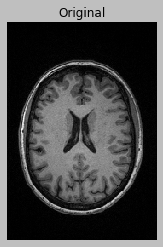

In [5]:
load_mr_image('example_1_T1w.nii.gz')

## Improving Images

In [18]:
def remove_noise_from_image(file_path, slice_num=0, display=False):
    medical_image = nib.load(file_path)
    image = medical_image.get_data()
    shape = medical_image.shape
    
    image_2d = image[:, :, slice_num]
    
    image_2d = np.rot90(image_2d)
    
    # We have to use a number greater than zero since
    # The image contains a lot of noise
    mask = image_2d <= 10
    
    selem = morphology.disk(2)
    
    # We have to use the mask to perform segmentation 
    # due to the fact that the original image is quite noisy
    segmentation = morphology.dilation(mask, selem)
    labels, label_nb = ndimage.label(segmentation)

    mask = labels == 0
    
    mask = morphology.dilation(mask, selem)
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, selem)
    
    clean_image = mask * image_2d

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(image_2d)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(142)
        plt.imshow(segmentation)
        plt.title('Background mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(mask)
        plt.title('Brain Mask')
        plt.axis('off')

        plt.subplot(144)
        plt.imshow(clean_image)
        plt.title('Clean Image')
        plt.axis('off')
    
    return clean_image

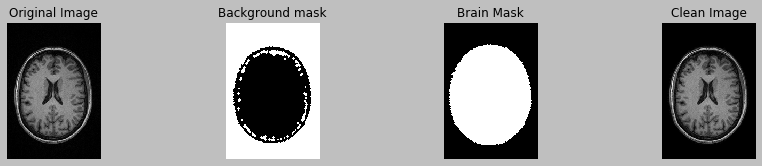

In [19]:
final_image = remove_noise_from_image('example_1_T1w.nii.gz', slice_num=144, display=True)

In [20]:
def add_pad(image, new_height=256, new_width=256):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) / 2)
    pad_top = int((new_height - height) / 2)
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

In [21]:
final_image = add_pad(final_image)

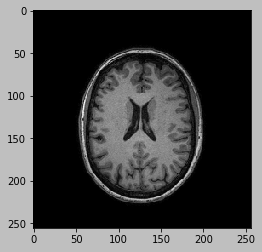

In [22]:
plt.imshow(final_image)

## Normalization

In [26]:
print(final_image.min(), "Min value")
print(final_image.max(), "Max Value")

0.0 Min value
540.0 Max Value


### Standardization

In [27]:
def standardization(image):
    # Get brain mask
    mask = image == 0
    
    selem = morphology.disk(2)
    
    segmentation = morphology.dilation(mask, selem)
    labels, label_nb = ndimage.label(segmentation)

    mask = labels == 0
    
    mask = morphology.dilation(mask, selem)
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, selem)
    
    # Normalize
    
    mean = image[mask].mean()
    std = image[mask].std()
    
    normalized_image = (image - mean) / std
    
    return normalized_image

In [28]:
normalized_image = standardization(final_image)

In [29]:
print(normalized_image.min(), "Min value")
print(normalized_image.max(), "Max Value")

-1.6427240336154347 Min value
3.5018470311518493 Max Value


### Fuzzy C-means-based Normalization

In [31]:
from skfuzzy import cmeans

In [43]:
def fcm_class_mask(image, brain_mask):
    # We want 3 classes with a maximum of 50 iterations
    [class_centers, partitioned_matrix, _, _, _, _, _] = cmeans(image[brain_mask].reshape(-1, len(brain_mask[brain_mask])),
                                              3, 2, 0.005, 50)
    
    # We use 'key' to sort by the values and not the index
    matrix_list = [partitioned_matrix[class_num] for class_num, _ in sorted(enumerate(class_centers),
                                                                          key=lambda x: x[1])] 
    mask = np.zeros(image.shape + (3,))
    
    for index in range(3):
        mask[..., index][brain_mask] = matrix_list[index]
    
    return mask

In [47]:
def get_white_matter_mask(image, threshold=0.8):
    # Get brain mask
    mask = image == 0
    
    selem = morphology.disk(2)
    
    segmentation = morphology.dilation(mask, selem)
    labels, label_nb = ndimage.label(segmentation)

    mask = labels == 0
    
    mask = morphology.dilation(mask, selem)
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, selem)
    
    # Get White Matter mask
    matrix_mask = fcm_class_mask(image, mask)
    white_matter_mask = matrix_mask[..., 2] > threshold
    
    plt.figure(figsize=(15, 2.5))
    plt.subplot(141)
    plt.imshow(matrix_mask)
    plt.title('matrix_mask')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(white_matter_mask)
    plt.title('white_matter_mask')
    plt.axis('off')
    
    return white_matter_mask   

In [48]:
def fcm_normalization(image, norm_value=1):
    white_matter_mask = get_white_matter_mask(image)
    wm_mean = image[white_matter_mask == 1].mean()
    
    normalized_image = (image / wm_mean) * norm_value
    
    return normalized_image

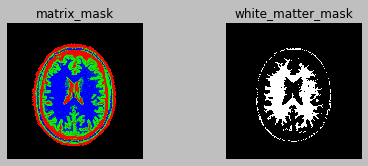

In [49]:
fcm_normalized_image = fcm_normalization(final_image)

In [50]:
print(fcm_normalized_image.min(), "Min value")
print(fcm_normalized_image.max(), "Max Value")

0.0 Min value
1.906068607467547 Max Value


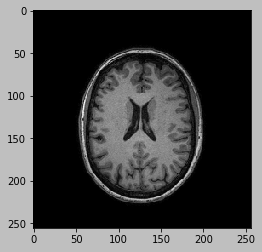

In [51]:
plt.imshow(fcm_normalized_image)

# PET Images

In [53]:
def load_pet_image(file_path, slice=65):
    medical_image = nib.load(file_path)
    image = medical_image.get_data()
    shape = medical_image.shape

    print(shape)

    image = np.rot90(image)

    image_2d = image[:, :, slice]
    
    # sum the time axis
    image_2d = np.sum(image_2d, axis=2)

    print(image.min(), "Min value")
    print(image.max(), "Max Value")
    
    return image_2d

In [55]:
pet_image = load_pet_image("example_1AV45_pet.nii.gz")

(256, 256, 127, 26)
0.0 Min value
144876.0 Max Value


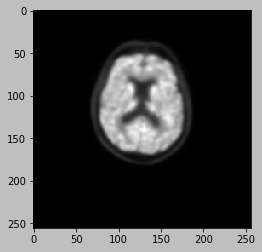

In [56]:
plt.imshow(pet_image)

In [57]:
print(pet_image.min(), "Min value")
print(pet_image.max(), "Max Value")

10.720023 Min value
326835.97 Max Value


In [60]:
normalized_image = (pet_image - pet_image.min()) / (pet_image.max() - pet_image.min())

In [61]:
print(normalized_image.min(), "Min value")
print(normalized_image.max(), "Max Value")

0.0 Min value
1.0 Max Value


In [62]:
normalized_image = (pet_image - pet_image.min()) * (255.0 / (pet_image.max() - pet_image.min()))

In [63]:
print(normalized_image.min(), "Min value")
print(normalized_image.max(), "Max Value")

0.0 Min value
255.0 Max Value
